# Primeiro Trabalho de Inteligência Artificial e Sistemas Inteligentes

## Aluno: Enzo B. Cussuol

O primeiro passo para resolução do trabalho é definir qual será a base de dados utilizada. Irei utilizar a base de dados *wine* da biblioteca *scikit-learn*.

A documentação referente ao *wine* encontra-se nesse [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html).

In [15]:
from sklearn import datasets

wine = datasets.load_wine()
wine_x = wine.data
wine_y = wine.target

Podemos utilizar a biblioteca *pandas* para auxiliar na visualização da base de dados.

In [16]:
import numpy as np
import pandas as pd

df = pd.DataFrame(data = np.c_[wine_x, wine_y],
                 columns = wine['feature_names'] + ['target'])
print(df)

     alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyan

Podemos ver que temos 178 instâncias, 13 características com valores numéricos e 3 classes, tal como consta na documentação da base de dados.

Com a base de dados disponível, podemos criar os classificadores. Como foi informado no trabalho, iremos utilizar o ZeroR (ZR), Naive Bayes Gaussiano (NBG), KMeans Centroides (KMC), K Vizinhos Mais Próximos (KNN) e Árvore de Decisão (AD). As implementações dos classificadores estão disponíveis no *scikit-learn*, com exceção do KMC, que será implementado manualmente.

In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

zR = DummyClassifier()
gNB = GaussianNB()
dKNN = KNeighborsClassifier()
dT = DecisionTreeClassifier()

E a implementação do KMC:

In [18]:
from sklearn.base import BaseEstimator
from sklearn.cluster import KMeans
from sklearn.utils.multiclass import unique_labels
import sys
from scipy.spatial import distance

class KMC(BaseEstimator):
    def __init__(self, k = 1):
        super().__init__()
        self.k = k
        self.centroides = []
    
    def fit(self,x_train,y_train):
        for classe in unique_labels(y_train):
            kM = KMeans(n_clusters = self.k)
            kM.fit(x_train[y_train == classe])
            self.centroides.append((kM.cluster_centers_, classe))
        
    def predict(self,x_test):
        predicoes = []
        
        for x in x_test:
            menorDistancia = sys.maxsize
            for centroidesPorClasse in self.centroides:
                for centroide in centroidesPorClasse[0]:
                    distancia = distance.euclidean(x, centroide)
                    if(distancia < menorDistancia):
                        menorDistancia = distancia
                        classePredita = centroidesPorClasse[1]
            predicoes.append(classePredita)
            
        return predicoes

kMC = KMC()

Agora que temos todos os classificadores, podemos treinar e testar os modelos. Para os classificadores ZR e NBG iremos utilizar 3 rodadas de validação cruzada estratificada de 10 folds.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

rkf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, 
                              random_state=36851234)

scalar = StandardScaler()

pipeline = Pipeline([('transformer', scalar), ('estimator', zR)])
scoresZR = cross_val_score(pipeline, wine_x, wine_y, scoring='accuracy', 
                           cv = rkf)

pipeline = Pipeline([('transformer', scalar), ('estimator', gNB)])
scoresGNB = cross_val_score(pipeline, wine_x, wine_y, scoring='accuracy', 
                           cv = rkf)

Para os classificadores KMC, KNN e AD iremos utilizar as mesmas 3 rodadas de validação cruzada estratificada de 10 folds, porém adicionando um ciclo interno de validação contendo 4 folds. Os valores de hiperparâmetros em cada ciclo interno seguirão as espeficações do trabalho, onde: KMC: [k = 1, 3, 5, 7], KNN: [n_neighbors = 1, 3, 5, 7] e AD: [max_depth = None, 3, 5, 10].

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

pipeline = Pipeline([('transformer', scalar), ('estimator', kMC)])
grade = {'estimator__k': [1, 3, 5, 7]}

gs = GridSearchCV(estimator=pipeline, param_grid = grade, 
                  scoring='accuracy', cv = StratifiedKFold(4))

scoresKMC = cross_val_score(gs, wine_x, wine_y, scoring='accuracy', 
                            cv = rkf)

pipeline = Pipeline([('transformer', scalar), ('estimator', dKNN)])
grade = {'estimator__n_neighbors': [1, 3, 5, 7]}

gs = GridSearchCV(estimator=pipeline, param_grid = grade, 
                  scoring='accuracy', cv = 4)

scoresDKNN = cross_val_score(gs, wine_x, wine_y, scoring='accuracy', 
                            cv = rkf)

pipeline = Pipeline([('transformer', scalar), ('estimator', dT)])
grade = {'estimator__max_depth': [None, 3, 5, 10]}

gs = GridSearchCV(estimator=pipeline, param_grid = grade, 
                  scoring='accuracy', cv = 4)

scoresDT = cross_val_score(gs, wine_x, wine_y, scoring='accuracy', 
                           cv = rkf)

Note que foi utilizada a normalização z-score nos treinamentos tal como requisitado pela documentação do trabalho.

Para comparar os resultados obtidos pelos classificadores, vamos utilizar as métricas média, desvio padrão, limite inferior e limite superior. Esses dados podem ser organizados na seguinte tabela:

In [21]:
from scipy import stats

def processaResultados(scores):
    mean = scores.mean()
    std = scores.std()
    inf, sup = stats.norm.interval(0.95, loc=mean, 
                               scale=std/np.sqrt(len(scores)))
    
    return mean, std, inf, sup

tabelaResultados = []

resultados = processaResultados(scoresZR)
tabelaResultados.append(['ZR', resultados[0], resultados[1], resultados[2], resultados[3]])

resultados = processaResultados(scoresGNB)
tabelaResultados.append(['NB', resultados[0], resultados[1], resultados[2], resultados[3]])

resultados = processaResultados(scoresKMC)
tabelaResultados.append(['KMC', resultados[0], resultados[1], resultados[2], resultados[3]])

resultados = processaResultados(scoresDKNN)
tabelaResultados.append(['KNN', resultados[0], resultados[1], resultados[2], resultados[3]])

resultados = processaResultados(scoresDT)
tabelaResultados.append(['AD', resultados[0], resultados[1], resultados[2], resultados[3]])

df = pd.DataFrame(tabelaResultados, columns = ['Método', 'Média', 'Desvio Padrão', 'Limite Inferior', 'Limite Superior'])
print(df)

  Método     Média  Desvio Padrão  Limite Inferior  Limite Superior
0     ZR  0.399346       0.024707         0.390505         0.408188
1     NB  0.973420       0.048205         0.956171         0.990670
2    KMC  0.962200       0.051889         0.943633         0.980768
3    KNN  0.960458       0.053188         0.941425         0.979490
4     AD  0.899020       0.065666         0.875522         0.922517


Além da tabela, podemos representar os resultados através de gráficos boxplot.

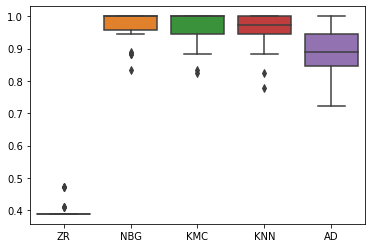

In [22]:
import seaborn as sns

scores = {'ZR': scoresZR, 'NBG': scoresGNB, 'KMC': scoresKMC, 
         'KNN': scoresDKNN, 'AD': scoresDT}
df = pd.DataFrame(scores)
output = sns.boxplot(data=df)

Para finalizar a análise dos resultados, vamos montar a tabela pareada dos resultados (p-values) dos testes de hipótese entre os pares de métodos. Na parte triangular superior estarão os resultados do teste t pareado e na parte triangular inferior estarão os resultados do teste não paramétrico de wilcoxon.

In [24]:
from scipy.stats import ttest_rel, wilcoxon

tabelaPareada = [[0 for x in range(5)] for y in range(5)]

tabelaPareada[0][0] = ('ZeroR', scoresZR)
tabelaPareada[1][1] = ('NB', scoresGNB)
tabelaPareada[2][2] = ('KMC', scoresKMC)
tabelaPareada[3][3] = ('KNN', scoresDKNN)
tabelaPareada[4][4] = ('AD', scoresDT)

for i in range(0, 5):
    for j in range(0, 5):
        if i != j:
            if i < j:
                s, p = ttest_rel(tabelaPareada[i][i][1], 
                                 tabelaPareada[j][j][1])
            if i > j:
                s, p = wilcoxon(tabelaPareada[i][i][1], 
                                tabelaPareada[j][j][1])
            tabelaPareada[i][j] = p

for i in range(0, 5):
    for j in range(0, 5):
        if i == j:
            print(tabelaPareada[i][j][0], " ", end="")
        else:
            print("%0.10f" % tabelaPareada[i][j], " ", end="")
    print("\n")

ZeroR  0.0000000000  0.0000000000  0.0000000000  0.0000000000  

0.0000008057  NB  0.0815437385  0.0527121786  0.0000000040  

0.0000012227  0.0704556178  KMC  0.7853676294  0.0000018952  

0.0000012490  0.1145886794  0.9628924378  KNN  0.0000000255  

0.0000014923  0.0000096559  0.0001441243  0.0000112140  AD  

